## 1. 이미지에서 텍스트 추출하기(easyOCR)

In [1]:
import easyocr
import numpy as np
import cv2
from typing import List, Dict
# from sklearn.cluster import KMeans

In [2]:
# 이미지 경로 지정
upload_image = 'test1.png'

In [6]:
reader = easyocr.Reader(['en'])
result = reader.readtext(upload_image)
print(result)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[12, 14], [540, 14], [540, 87], [12, 87]], 'It was the best of', 0.9658043444948076), ([[7, 99], [686, 99], [686, 178], [7, 178]], 'times, it was the worst', 0.8693864604697936), ([[11, 181], [697, 181], [697, 267], [11, 267]], 'of times, it was the age', 0.7349637559231157), ([[11, 256], [649, 256], [649, 345], [11, 345]], 'of wisdom; it was the', 0.8425616344866556), ([[7, 344], [563, 344], [563, 433], [7, 433]], 'age of foolishness .', 0.8389083561447452)]


In [7]:
OCR_RESULTS = []
print("✅ Result : ")
for res in result:
    OCR_RESULTS.append(res[0:2])
    print(res[0:2])


✅ Result : 
([[12, 14], [540, 14], [540, 87], [12, 87]], 'It was the best of')
([[7, 99], [686, 99], [686, 178], [7, 178]], 'times, it was the worst')
([[11, 181], [697, 181], [697, 267], [11, 267]], 'of times, it was the age')
([[11, 256], [649, 256], [649, 345], [11, 345]], 'of wisdom; it was the')
([[7, 344], [563, 344], [563, 433], [7, 433]], 'age of foolishness .')


## 2. 추출된 텍스트 번역
- 추출된 각 텍스트 영역에서 문맥상 이어지면 전체 문장을 고려하여 번역을 수행하고 다시 각 영역에 적절하게 번역된 텍스트 분배

In [8]:
from langchain.prompts import PromptTemplate
from langchain_core.prompts import load_prompt
from langchain_community.chat_models import ChatOpenAI

In [9]:
source_lang = "en"
target_lang = "ko"

### Translation Chain 생성

In [10]:
import ast

prompt = load_prompt("../../prompts/OCR_translate_paragraph.yaml", encoding="utf-8")

llm = ChatOpenAI(model_name="gpt-4o", temperature=0.2)
chain = prompt | llm

llm_result = chain.invoke({
    "OCR_RESULTS": OCR_RESULTS,
    "source_lang": source_lang,
    "target_lang": target_lang}
    )

def clean_content(content):
    # 첫 번째 '[' 위치 찾기
    start_idx = content.find('[')
    if start_idx == -1:  # '[' 가 없는 경우
        return content
    
    # '[' 이후의 내용만 추출
    cleaned_content = content[start_idx:]
    return cleaned_content

# 문자열 정제 후 Python 객체로 변환
cleaned_content = clean_content(llm_result.content)
print("정제된 내용:")
print(cleaned_content)

translated_results = ast.literal_eval(cleaned_content)

for index, result in enumerate(translated_results):
    print(f"\n결과 {index + 1}:")
    print(result)

C:\Users\COM-PPJU\AppData\Local\Temp\ipykernel_10352\1689995558.py:5: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model_name="gpt-4o", temperature=0.2)


정제된 내용:
[([[12, 14], [540, 14], [540, 87], [12, 87]], '최고의 시기였다'), ([[7, 99], [686, 99], [686, 178], [7, 178]], '최악의 시기였다'), ([[11, 181], [697, 181], [697, 267], [11, 267]], '지혜의 시대였다'), ([[11, 256], [649, 256], [649, 345], [11, 345]], '어리석음의 시대였다'), ([[7, 344], [563, 344], [563, 433], [7, 433]], '어리석음의 시대였다.')]

결과 1:
([[12, 14], [540, 14], [540, 87], [12, 87]], '최고의 시기였다')

결과 2:
([[7, 99], [686, 99], [686, 178], [7, 178]], '최악의 시기였다')

결과 3:
([[11, 181], [697, 181], [697, 267], [11, 267]], '지혜의 시대였다')

결과 4:
([[11, 256], [649, 256], [649, 345], [11, 345]], '어리석음의 시대였다')

결과 5:
([[7, 344], [563, 344], [563, 433], [7, 433]], '어리석음의 시대였다.')


### 후처리
- llm_chain에서 받은 결과가 완전하게 List 구조가 아닐 경우 에러 발생
- 따라서 발생가능성이 있는 상황에 대해 핸들러 추가
- llm_chain으로부터 답변 받은 내용은 문자열이기 때문에 이를 python 객체로 변환

## 3. 번역된 텍스트 융합 (fusing translated-text into the image)

In [12]:
# # translated_text 전처리
# def adjust_bounding_boxes(translated_results):
#     # 바운딩 박스의 첫 번째 좌표의 x 값을 기준으로 정렬
#     translated_results.sort(key=lambda x: x[0][0][0])
    
#     # 조정된 결과를 저장할 리스트
#     adjusted_results = []
    
#     # 현재 그룹의 시작 인덱스
#     group_start_index = 0
    
#     for i in range(1, len(translated_results)):
#         # 현재 바운딩 박스의 첫 번째 좌표의 x 값
#         current_x = translated_results[i][0][0][0]
#         # 이전 바운딩 박스의 첫 번째 좌표의 x 값
#         previous_x = translated_results[i-1][0][0][0]
        
#         # x 좌표 차이가 5px 이내인지 확인
#         if current_x - previous_x > 5:
#             # 그룹 내의 모든 바운딩 박스를 최솟값으로 조정
#             min_x = min(translated_results[j][0][0][0] for j in range(group_start_index, i))
#             for j in range(group_start_index, i):
#                 bbox, text = translated_results[j]
#                 # x 좌표 조정 (첫 번째와 네 번째 좌표)
#                 adjusted_bbox = [
#                     [min_x, bbox[0][1]],  # 첫 번째 좌표
#                     bbox[1],              # 두 번째 좌표
#                     bbox[2],              # 세 번째 좌표
#                     [min_x, bbox[3][1]]   # 네 번째 좌표
#                 ]
#                 adjusted_results.append((adjusted_bbox, text))
            
#             # 새로운 그룹 시작
#             group_start_index = i
    
#     # 마지막 그룹 처리
#     min_x = min(translated_results[j][0][0][0] for j in range(group_start_index, len(translated_results)))
#     for j in range(group_start_index, len(translated_results)):
#         bbox, text = translated_results[j]
#         adjusted_bbox = [
#             [min_x, bbox[0][1]],  # 첫 번째 좌표
#             bbox[1],              # 두 번째 좌표
#             bbox[2],              # 세 번째 좌표
#             [min_x, bbox[3][1]]   # 네 번째 좌표
#         ]
#         adjusted_results.append((adjusted_bbox, text))
    
#     return adjusted_results


In [13]:
# adjusted_results = adjust_bounding_boxes(translated_results)

# for result in adjusted_results:
#     print(result)

In [28]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from collections import Counter
from PIL import Image, ImageDraw, ImageFont
import math

font_path = r"C:\Users\COM-PPJU\AppData\Local\Microsoft\Windows\Fonts\NanumGothic.ttf"

def create_mask(image, bbox):
    """바운딩 박스 영역의 마스크 생성"""
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    pts = np.array(bbox, np.int32)
    cv2.fillPoly(mask, [pts], 255)
    return mask

def extract_text_size(image, bbox):
    """원본 텍스트의 스타일(색상, 폰트 크기 등)을 추출하는 함수"""
    # 바운딩 박스 영역 추출
    x1, y1 = bbox[0]
    x2, y2 = bbox[2]
    bbox_width = x2 - x1
    bbox_height = y2 - y1
    text_region = image[y1:y2, x1:x2]

    # text_region 시각화
    plt.imshow(cv2.cvtColor(text_region, cv2.COLOR_BGR2RGB))
    plt.title("Text Region")
    plt.show()
    
    # 폰트 크기 추정 (바운딩 박스 높이 사용)
    # font_size = math.floor(y2 - y1 - 10)
    font_size = math.floor(bbox_height - 2(bbox_width/bbox_width))
    print("바운딩박스 높이 : ", bbox_height)
    print("바운딩박스 너비 : ", bbox_width)
    print("font_size : ",font_size)
    
    return (0,0,0), font_size

In [36]:
def process_image_with_steps(image_path, translated_results, original_results):
    # 1. 원본 이미지 로드
    original_image = cv2.imread(image_path)
    image = original_image.copy()
    
    # 2. 마스크 생성
    combined_mask = np.zeros(image.shape[:2], dtype=np.uint8)
    for bbox, _ in original_results:
        mask = create_mask(image, bbox)
        combined_mask = cv2.bitwise_or(combined_mask, mask)
    
    # 3. 텍스트 영역 제거된 이미지 생성
    masked_image = image.copy()
    masked_image[combined_mask == 255] = [255, 255, 255]  # 흰색으로 채우기
    
    # 4. 인페인팅으로 텍스트 영역 채우기
    inpainted_image = cv2.inpaint(image, combined_mask, 3, cv2.INPAINT_TELEA)
    
    # 5. 번역된 텍스트 추가
    translated_image = Image.fromarray(cv2.cvtColor(inpainted_image, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(translated_image)


    
    # 폰트 설정 (적절한 경로로 변경)

    for bbox, translated_text in translated_results:
        # 박스 크기 계산
        x_coords = [p[0] for p in bbox]
        y_coords = [p[1] for p in bbox]
        box_width = max(x_coords) - min(x_coords)
        box_height = max(y_coords) - min(y_coords)

        # text_region 시각화
        x1, y1 = bbox[0]
        x2, y2 = bbox[2]
        text_region = image[y1:y2, x1:x2]

        plt.imshow(cv2.cvtColor(text_region, cv2.COLOR_BGR2RGB))
        plt.title("Text Region")
        plt.show()
        
        # 폰트 크기 추정 (바운딩 박스 높이 사용)
        # font_size = math.floor(y2 - y1 - 10)
        font_size = math.floor(box_height - 2*(box_width/box_height))
        font_size = 5 * round(font_size / 5)
        print("바운딩박스 높이 : ", box_height)
        print("바운딩박스 너비 : ", box_width)
        print("font_size : ",font_size)

        font = ImageFont.truetype(font_path, font_size)

        # 텍스트 상자 크기 계산
        text_bbox = font.getbbox(translated_text)
        text_width = text_bbox[2] - text_bbox[0]
        text_height = text_bbox[3] - text_bbox[1]

        # 텍스트 위치 계산
        x = min(x_coords)
        y = min(y_coords) + (box_height - text_height) // 2
        
        # 텍스트
        draw.text((x, y), translated_text, font=font, fill=(0, 0, 0))
    
    # matplotlib 폰트 설정
    plt.rcParams['font.family'] = 'NanumGothic'
    plt.rcParams['axes.unicode_minus'] = False

    # 폰트 추가
    fm.fontManager.addfont(font_path)
    plt.rcParams['font.family'] = 'NanumGothic'

    # 결과 시각화
    plt.imshow(translated_image)
    plt.show()
    
    return translated_image

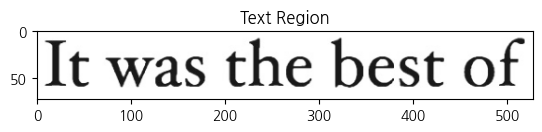

바운딩박스 높이 :  73
바운딩박스 너비 :  528
font_size :  60


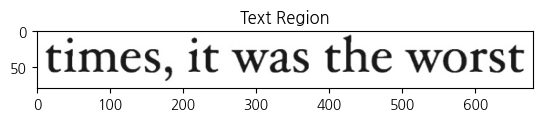

바운딩박스 높이 :  79
바운딩박스 너비 :  679
font_size :  60


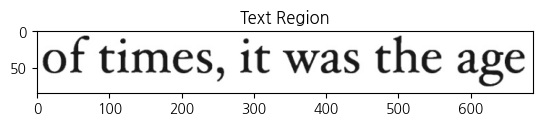

바운딩박스 높이 :  86
바운딩박스 너비 :  686
font_size :  70


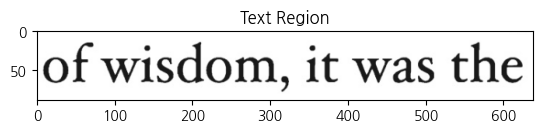

바운딩박스 높이 :  89
바운딩박스 너비 :  638
font_size :  75


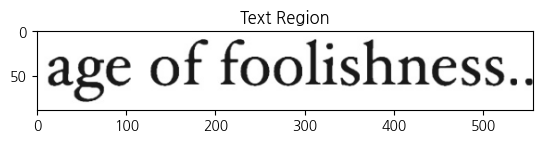

바운딩박스 높이 :  89
바운딩박스 너비 :  556
font_size :  75


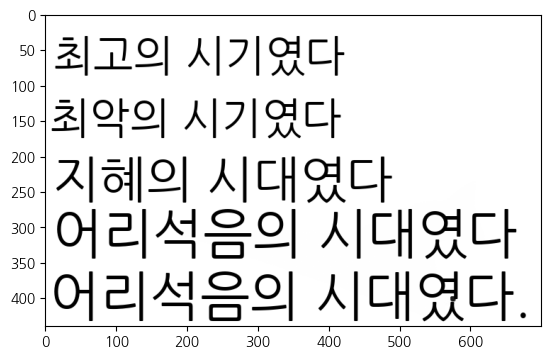

In [37]:
# 사용 예시
image_path = "./test1.png"
result_image = process_image_with_steps(image_path, translated_results, OCR_RESULTS)

# # 결과 저장
# result_image.save("translated_image3_2.png")

In [69]:
upload_image = 'test2.jpg'

In [70]:
reader = easyocr.Reader(['en','ko'])
result = reader.readtext(upload_image)
print(result)
OCR_RESULTS = []
print("✅ Result : ")
for res in result:
    OCR_RESULTS.append(res[0:2])
    print(res[0:2])

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[53, 13], [95, 13], [95, 33], [53, 33]], '타고', 0.9997480554364656), ([[58, 32], [92, 32], [92, 40], [58, 40]], 'arodki', 0.3791796332205188), ([[384, 14], [502, 14], [502, 44], [384, 44]], '1개월 단위로', 0.9700136254547718), ([[326, 40], [502, 40], [502, 70], [326, 70]], '전기차가 필요할 때!', 0.9603615808307685), ([[356, 70], [501, 70], [501, 110], [356, 110]], '타고 월렌트', 0.8489464132429355), ([[339, 117], [497, 117], [497, 133], [339, 133]], '070-5067-3100 / wWW tagokr', 0.6976330150153751)]
✅ Result : 
([[53, 13], [95, 13], [95, 33], [53, 33]], '타고')
([[58, 32], [92, 32], [92, 40], [58, 40]], 'arodki')
([[384, 14], [502, 14], [502, 44], [384, 44]], '1개월 단위로')
([[326, 40], [502, 40], [502, 70], [326, 70]], '전기차가 필요할 때!')
([[356, 70], [501, 70], [501, 110], [356, 110]], '타고 월렌트')
([[339, 117], [497, 117], [497, 133], [339, 133]], '070-5067-3100 / wWW tagokr')


In [71]:
source_lang = "ko"
target_lang = "en"

In [74]:
prompt = load_prompt("../../prompts/OCR_translate_paragraph.yaml", encoding="utf-8")

llm = ChatOpenAI(model_name="gpt-4o", temperature=0.2)
chain = prompt | llm

llm_result = chain.invoke({
    "OCR_RESULTS": OCR_RESULTS,
    "source_lang": source_lang,
    "target_lang": target_lang}
    )

translated_results = ast.literal_eval(llm_result.content)

for index, result in enumerate(translated_results):
    print(result)

([[53, 13], [95, 13], [95, 33], [53, 33]], 'Tago')
([[58, 32], [92, 32], [92, 40], [58, 40]], 'arodki')
([[384, 14], [502, 14], [502, 44], [384, 44]], 'Monthly basis')
([[326, 40], [502, 40], [502, 70], [326, 70]], 'When you need an electric car!')
([[356, 70], [501, 70], [501, 110], [356, 110]], 'Tago Monthly Rent')
([[339, 117], [497, 117], [497, 133], [339, 133]], '070-5067-3100 / www.tagokr')


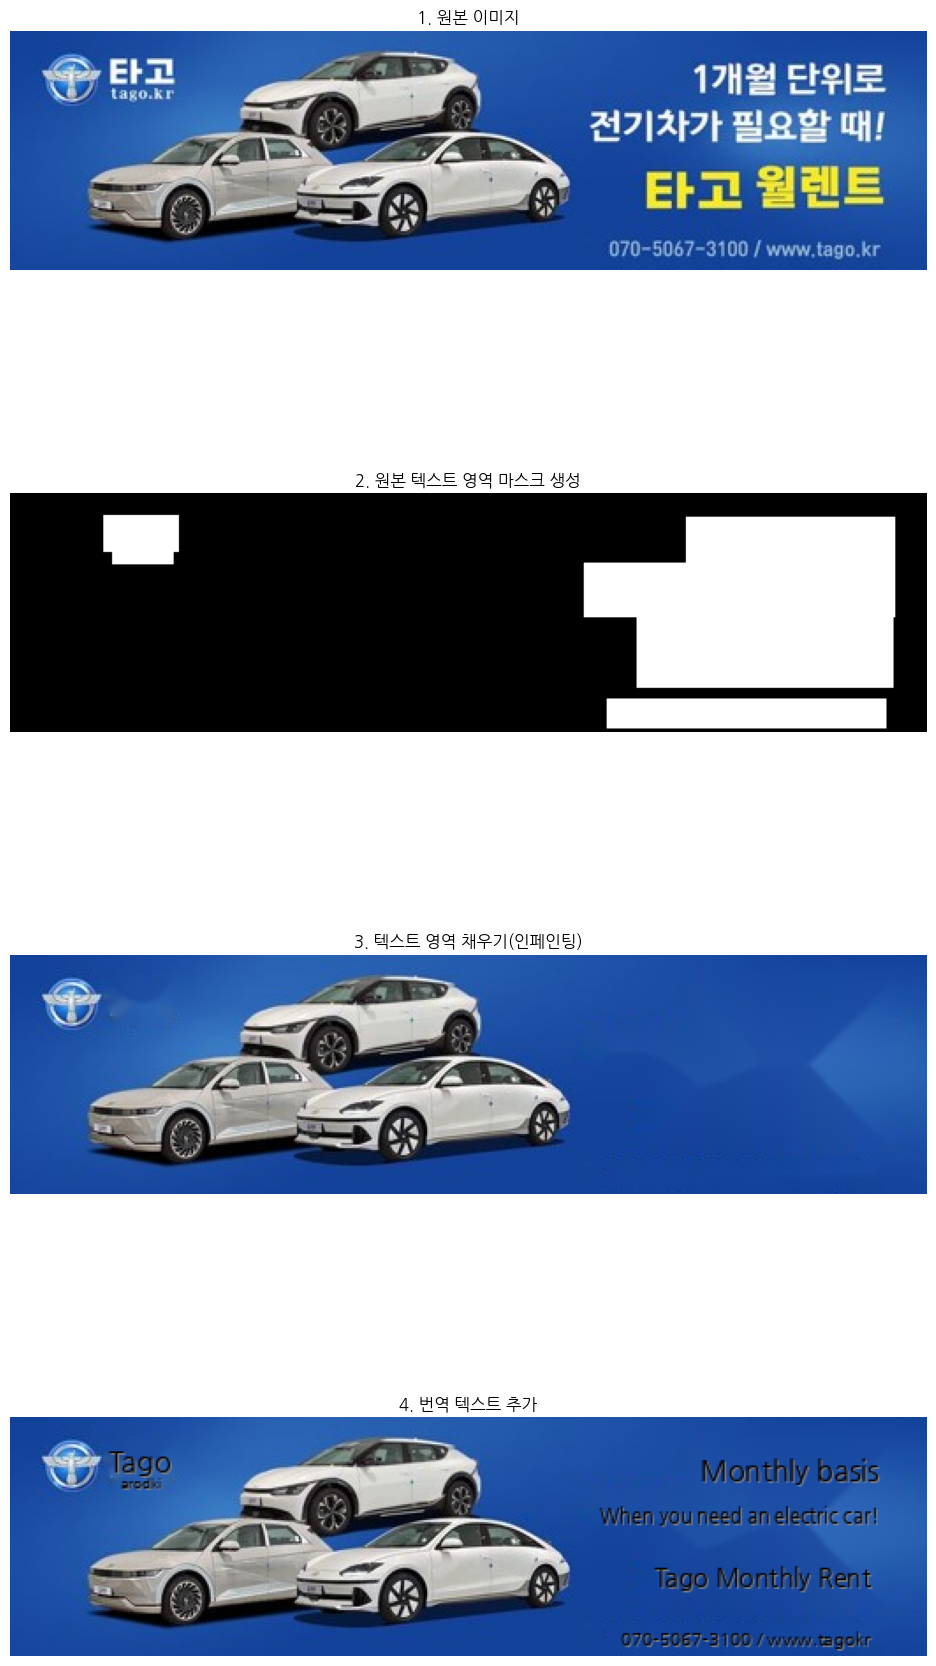

In [75]:
result_image = process_image_with_steps(upload_image, translated_results, OCR_RESULTS)

result_image.save("translated_image3.png")